<h1 style="font-size:35px;
        color:black;
        ">Quantum Hadamard Edge Detection on Small Images</h1>

In [1]:
# importing the libraries
from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import style
from PIL import Image
style.use('bmh')

<h2 style="font-size:24px;">Preparing the image</h2>

We first import an image and change it from the classical interpretation to the Quantum Probability Image Encoding (QPIE) state. To do this, we need to normalize all the pixel intensities.

Let the original image with $n$ pixels be represented by vector $$(a_0 a_1 a_2 \dots a_{n-1}).$$

We can define each pixel of the QPIE state of the image to be $$b_i = \frac{a_i}{\sqrt{\sum_{k = 0}^{n-1} a_k^2}}.$$

Using QPIE, we are able to exponentially reduce memory for storing BW or RGB images. A $n$ pixel image would only need $\lceil \log_2{n} \rceil$ qubits. QPIE also uses less resources than similar quantum image representation methods like FRQI or NEQR.

In [2]:
# A square grayscale image respresented as a numpy array
temp = Image.open('star64.jpg').convert('L')
image = np.asarray(temp).astype('float64')
image /= 256
#print(image)

# Function for plotting the image using matplotlib
def plot_image(img, title: str):
    plt.title(title)
    #plt.xticks(range(img.shape[0]))
    #plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap = 'Greys')
    plt.show()
    
plot_image(image, 'Original Image')

FileNotFoundError: [Errno 2] No such file or directory: 'star64.jpg'

In [140]:
# Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

# Get the amplitude ancoded pixel values
# Horizontal: Original image
image_norm_h = amplitude_encode(image)

# Vertical: Transpose of Original image
image_norm_v = amplitude_encode(image.T)

<h2 style="font-size:24px;">QHED Algorithm</h2>

After changing the image to its QPIE state, we apply the QHED algorithm to the image.
<h4 style="font-size: 17px">Auxiliary qubit:</h4>

We begin by adding an auxiliary qubit initialized to state $|0 \rangle$. The purpose of the auxiliary qubit is to be able to find all the edges in one direction (horizontal or vertical) in one pass. We apply the $H$-gate to the auxiliary qubit and get the following image state: 
$$|\text{image}\rangle \otimes \frac{|0\rangle + |1\rangle}{\sqrt2} = \frac{1}{\sqrt2} 
\begin{bmatrix}
b_0 \\
b_0 \\
b_1 \\
b_1 \\
b_2 \\
\vdots\\
b_{n-1}\\
b_{n-1}\\
\end{bmatrix}$$

We then apply a unitary decrement gate to the image state to get $(b_0, b_1, b_1, b_2, b_2, \dots, b_{n-1}, b_{n-1}, b_0)^T$, shifting the first element to the end.

<h4 style="font-size: 17px">Applying the Hadamard gates:</h4>

Because we want to find the boundary of the image, we are interested in the difference between neighboring pixels. This operation can be represented as $$I_{2^{n-1}} \otimes H = \frac{1}{\sqrt2} \begin{bmatrix}
1 & 1 & 0 & 0 & \dots & 0 & 0 \\
1 & -1 & 0 & 0 & \dots & 0 & 0 \\
0 & 0 & 1 & 1 & \dots & 0 & 0 \\
0 & 0 & 1 & -1 & \dots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots  \\
0 & 0 & 0 & 0 & \dots & 1 & 1 \\
0 & 0 & 0 & 0 & \dots & 1 & -1 \\
\end{bmatrix}$$

Applying this operation to the image state, we get $$(I_{2^{n-1}} \otimes H) \cdot \begin{bmatrix}
b_0 \\
b_1 \\
b_1 \\
b_2 \\
\vdots\\
b_{n-1}\\
b_{n-1}\\
b_{0}\\
\end{bmatrix}
= \frac{1}{\sqrt2} 
\begin{bmatrix}
b_0 + b_1 \\
b_0 - b_1 \\
b_1 + b_2\\
b_1 - b_2 \\
\vdots\\
b_{n-2} - b_{n-1}\\
b_{n-1} + b_{0}\\
b_{n-1} - b_{0}\\
\end{bmatrix}$$

Because this operation will only find the edges for one dimension, we will find the other direction by repeating the operation on the transpose of the image.

In [141]:
# Initialize some global variable for number of qubits
data_qb = math.ceil(np.log(image.size) / np.log(2))
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the decrement unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

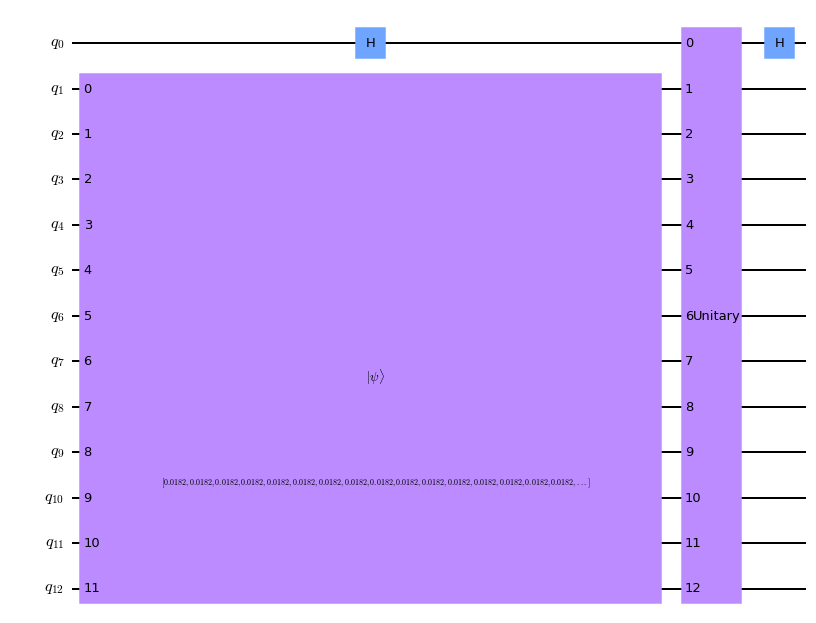

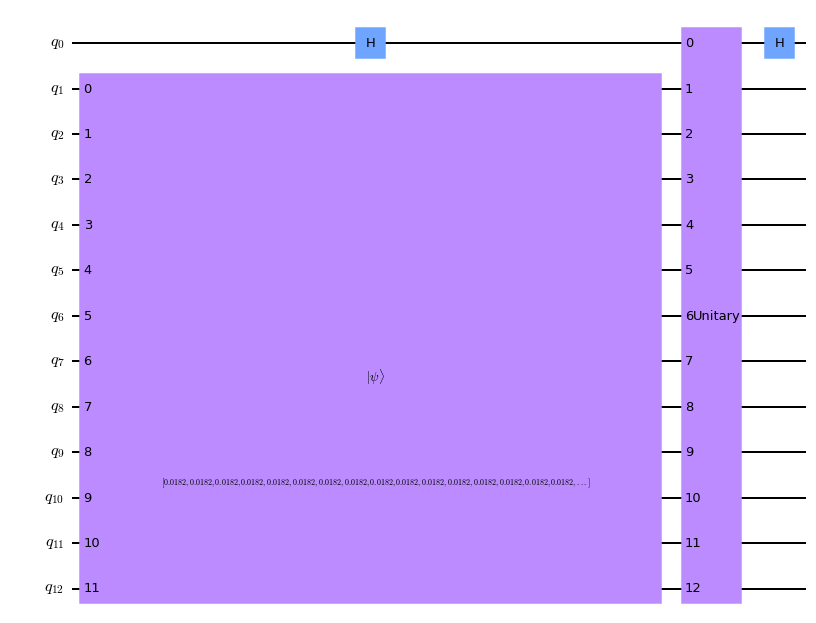

In [142]:
# Create the circuit for horizontal scan
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
display(qc_h.draw('mpl', fold=-1))

# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
display(qc_v.draw('mpl', fold=-1))

# Combine both circuits into a single list
circ_list = [qc_h, qc_v]

In [143]:
# Simulating the cirucits
back = Aer.get_backend('statevector_simulator')
results = execute(circ_list, backend=back).result()
sv_h = results.get_statevector(qc_h)
sv_v = results.get_statevector(qc_v)

from qiskit.visualization import array_to_latex
print('Horizontal scan statevector:')
display(array_to_latex(sv_h[:30], max_size=30))
print()
print('Vertical scan statevector:')
display(array_to_latex(sv_v[:30], max_size=30))

Horizontal scan statevector:


<IPython.core.display.Latex object>


Vertical scan statevector:


<IPython.core.display.Latex object>

<h2 style="font-size:24px;">Post-processing</h2>

To find the edges of the image, we only need look at the differences between adjacent pixels. To do this, we measure the auxiliary qubit on state $|1\rangle$. After doing this to both the horizontal and vertical components, we can combine the edges to get the final result.

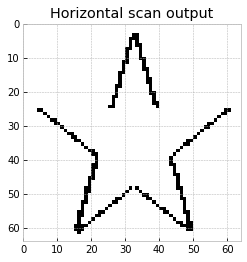

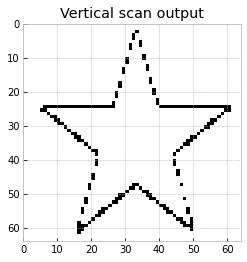

In [144]:
# Classical postprocessing for plotting the output

# Defining a lambda function for
# thresholding to binary values
threshold = lambda amp: (amp > 0.002 or amp < -0.002)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(image.shape[0], image.shape[1])
edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(image.shape[0], image.shape[1]).T

# Plotting the Horizontal and vertical scans
plot_image(edge_scan_h, 'Horizontal scan output')
plot_image(edge_scan_v, 'Vertical scan output')

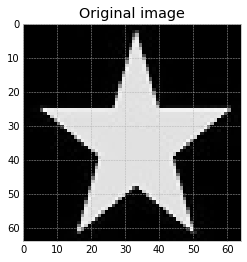

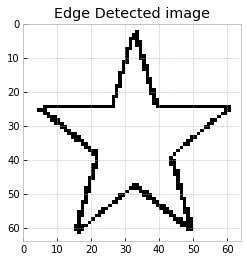

In [145]:
# Combining the horizontal and vertical component of the result
edge_scan_sim = edge_scan_h | edge_scan_v

# Plotting the original and edge-detected images
plot_image(image, 'Original image')
plot_image(edge_scan_sim, 'Edge Detected image')